In [4]:
import sys
sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")

my_modules = ['plot_functions', 'load_model_output', 'search_functions']
for mod in my_modules:
    if mod in sys.modules: 
        del sys.modules[mod]


from search_functions import *
from load_model_output import *
from plot_functions import *

In [5]:
import ipywidgets as widgets
dirs = os.listdir(os.path.join(project_dir , 'model_output/'))
dirs = list(set(dirs) - {'.DS_Store'})

select_base_name = widgets.Dropdown(
    options=dirs,
    description='base_name:',
    disabled=False,
)
select_base_name

Dropdown(description='base_name:', options=('test_GW_GA', 'test_inflow_dx', 'test_stripe', 'test_veg', 'test_i…

In [6]:
project_dir = "/Users/octavia/Dropbox/SVE_v2/"
base_name = select_base_name.value
base_dir = os.path.join(project_dir, 'model_output', base_name )

print_input_params(base_dir, ["dx"])

batch:
	Ks : 5.0
	H_i : 0.0, -0.01, -0.1
sim:
	fV : 0.2, 0.4, 0.6
	p : 3.0, 5.0
common:
	dx : 1.0


In [7]:
core = load_sims(base_dir)
core = patchy_update(core)
core.runtime_hr

H_i--0.01,Ks-5.0/fV-0.6,p-3.0/      0.05618
H_i--0.01,Ks-5.0/fV-0.4,p-3.0/    0.0664102
H_i--0.01,Ks-5.0/fV-0.2,p-3.0/    0.0754202
H_i--0.01,Ks-5.0/fV-0.6,p-5.0/    0.0606088
H_i--0.01,Ks-5.0/fV-0.2,p-5.0/    0.0759742
H_i--0.01,Ks-5.0/fV-0.4,p-5.0/     0.069102
H_i-0.0,Ks-5.0/fV-0.6,p-3.0/      0.0591815
H_i-0.0,Ks-5.0/fV-0.4,p-3.0/      0.0681934
H_i-0.0,Ks-5.0/fV-0.2,p-3.0/      0.0759504
H_i-0.0,Ks-5.0/fV-0.6,p-5.0/      0.0627139
H_i-0.0,Ks-5.0/fV-0.2,p-5.0/      0.0756212
H_i-0.0,Ks-5.0/fV-0.4,p-5.0/      0.0703049
H_i--0.1,Ks-5.0/fV-0.6,p-3.0/     0.0522624
H_i--0.1,Ks-5.0/fV-0.4,p-3.0/     0.0634558
H_i--0.1,Ks-5.0/fV-0.2,p-3.0/     0.0726139
H_i--0.1,Ks-5.0/fV-0.6,p-5.0/     0.0556432
H_i--0.1,Ks-5.0/fV-0.2,p-5.0/     0.0733944
H_i--0.1,Ks-5.0/fV-0.4,p-5.0/     0.0660525
Name: runtime_hr, dtype: object

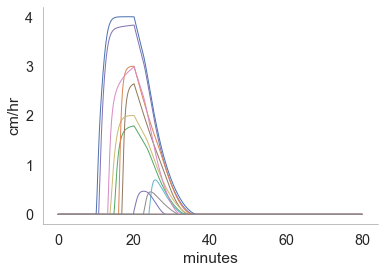

In [8]:
fig = plot_hydrographs(core[:20])

In [9]:
dum = filter_core(core, criteria = {"Ks" : 5, "p" : 2}, quality = None)
dum.index

Index([], dtype='object')

In [10]:
name_vars = get_name_vars(base_dir)
names =  get_name_tuples(core, name_vars)

def get_widget():
    select = widgets.Dropdown(
        options=names,
        description='Name:')
    return select

In [36]:
def patchy_update(core):
    """

    TODO: merge into general update        
    """
    sims = dict(core.T)

    for key in sims.keys():
        sim = pd.Series(sims[key])
        sims[key] = pd.Series(sims[key])
        if "xflux0" not in sim:        
            sims[key]['qc'] =  sim.uc * sim.hc
        else:   
            sims[key]['qc'] =  sim.xflux0/sim.dx
            
        sims[key]['qc_1D'] = sims[key]['qc'].mean(1)


#         L_v = sim.veg.mean(0).sum() * sim.dx
#         alpha = sim.alpha
#         Kr_v = sim.So ** .5 / alpha

#         alphaB = sim.alphaB
#         Kr_b = sim.So ** .5 / alphaB
#         L_b = (sim.ncol - sim.veg.mean(0).sum()) * sim.dx

#         a = sim.m

#         p = sim.rain

#         sims[key]['L_b'] = L_b
#         sims[key]['L_v'] = L_v

#         sims[key]['t_ac'] = (L_b / Kr_b / p ** a) ** (1. / (a + 1)) / 60.
#         sims[key]['t_ad'] = L_v * Kr_v ** (-1. / (a + 1)) * (L_b * p) ** (
#                     -a / (a + 1.)) / 60.

#         sims[key]['ac_dc'] = L_b / L_v * (Kr_v / Kr_b) ** (1. / (a + 1))

    core = pd.DataFrame(sims).T

    return core


In [57]:
def compute_Lv(sim, trim = None):
    """
    'patchy code': yet to be developed, draw on ravel_functions_RF.
    """
    L_v = sim.veg.mean(0).sum() * sim.dx
    if trim is not none:
        L_v = sim.veg.mean(0)[-trim:].sum() * sim.dx                          
    return L_v

def compute_Lb(sim):
    """
    Todo: refine for patchy code
    """
    L_b = (sim.ncol - sim.veg.mean(0).sum()) * sim.dx
    return L_b

def compute_Ta(sim, trim):
    
        L_v = compute_Lv(sim, trim)
        alpha = sim.alpha
        Kr_v = sim.So ** .5 / alpha

        Kr_b = sim.So ** .5 / sim.alphaB
        L_b =  compute_Lb(sim)

        m = sim.m
        rain = sim.rain    
        
        T_a = (L_b / Kr_b / rain ** m) ** (1. / (m + 1)) 
        return T_a

In [37]:
core = patchy_update(core)

In [39]:
sim = core.iloc[0]

In [40]:
sim.veg.mean(0).shape

(100,)

In [52]:
def plot_Ta_Tc(keyA, keyB, core, ax = None, ind = None):
    """
     Plot 'fluxes' for two simulations, A and B
    Not mass conserving!
    """
    if not ax:
        ax = plt.gca()
        
    simA = core.loc[keyA]
    IF_A = simA.infl_2d[:, ind:].mean()

    plt.plot(simA.t_print/60, simA.qc_1D[:, ind]*1e4, 
                 label = "A")

    simB = core.loc[keyB]
    
    ax.plot(simB.t_print/60,simB.qc_1D[:, ind]*1e4, label = "B")
    IF_B = simB.infl_2d[:, ind:].mean()
    legend = ax.legend(title = "$T_A/T_C$")
    plt.setp(legend.get_title(),fontsize='large')

    ax.set_xlabel("min")
    ax.set_ylabel("$q$ (cm$^2$/s)")

In [54]:

selectB = get_widget()
selectB

Dropdown(description='Name:', options=(('H_i=-0.01, fV=0.6, p=3.0', 'H_i--0.01,Ks-5.0/fV-0.6,p-3.0/'), ('H_i=-…

In [53]:
selectA = get_widget()
selectA

Dropdown(description='Name:', options=(('H_i=-0.01, fV=0.6, p=3.0', 'H_i--0.01,Ks-5.0/fV-0.6,p-3.0/'), ('H_i=-…

H_i--0.01,Ks-5.0/fV-0.6,p-3.0/
H_i-0.0,Ks-5.0/fV-0.4,p-5.0/


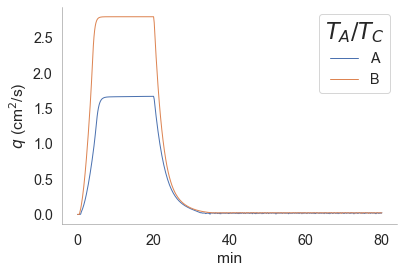

In [56]:

keyA = selectA.value
print(keyA)
keyB = selectB.value
print(keyB)

keyA = "H_i--0.01,Ks-5.0/fV-0.6,p-3.0/"
keyB = "H_i-0.0,Ks-5.0/fV-0.4,p-5.0/"

# plt.plot(core.loc[keyA].flux3)
plot_Ta_Tc(keyA, keyB,core,ind=20)

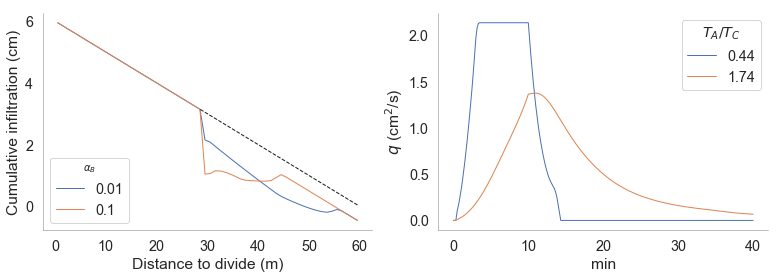

In [12]:
def compare_infl_profile(keyA, keyB, core, ax):
    """
    """

    simA = core.loc[keyA]
    IF_A = simA.infl_2d[:, 20:].mean()
    ax.plot(simA.d2divide,  simA.zc[1, :]*10 - simA.infl_2d[1,:], '-', label = np.round(simA.alphaB,2))


    simB = core.loc[keyB]
    ax.plot(simB.d2divide, simB.zc[1, :]*10 - simB.infl_2d[1,:], '-', label = np.round(simB.alphaB,2))
    IF_B = simB.infl_2d[:, 20:].mean()

    ind = range(np.max(np.where(simA.isvegc[1] > 0.2)[0])+2)
    ax.plot(simB.d2divide[ind], simB.zc[1, ind]*10, 'k--',lw = 1)
    ax.set_xlabel("Distance to divide (m)")
    ax.set_ylabel("Cumulative infiltration (cm)")
    ax.legend(title=r"$\alpha_B$", loc="lower left")

fig, axes = plt.subplots(1, 2,  figsize =(13,4))
plt.subplots_adjust(wspace=0.2)

compare_infl_profile(keyA, keyB, core,  axes[0])

ind = np.max(np.where(core.loc[keyA].isvegc[1] > 0.)[0])
plot_Ta_Tc(keyA, keyB, core, axes[1], ind+2, smooth_peak=1)

# Sharp spike hopefully will disappear with real fluxes
# Iron out profile plot

In [13]:
key = "p-3/Ks-3,alphaB-0.1,So-0.01/"
sim = core.loc[key]



(<Figure size 792x432 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x11cd52810>)

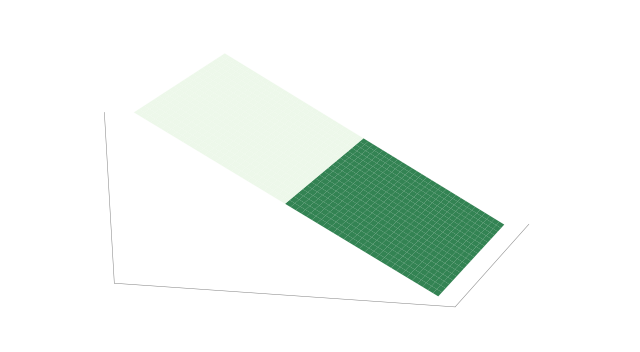

In [14]:
plot_3D_veg(sim)

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x11eebfdd0>)

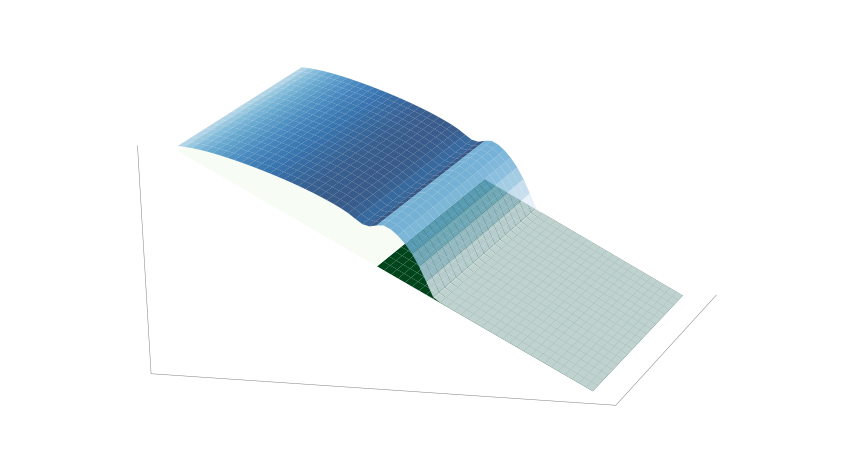

In [15]:
plot_U_surface(sim)

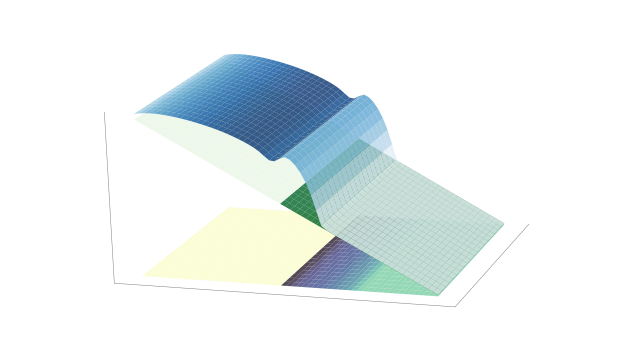

In [16]:
plot_3D_fhU(sim);

# Relevant to `AC_DC_resolve3` simulations

    fig, ax=plt.subplots(1, figsize = (6,4))
    key =  u'tr-30/alphaB-0.01,alpha-0.05,So-0.02/'

    sim_As_Cs = core.loc[key]
    IF_A = sim_As_Cs.zinflc[:, 20:].mean()
    p = plt.plot(sim_As_Cs.t_p/60, sim_As_Cs.qc1[:, 1]*1e4, '--', lw = 2,
                 label = "{0:.0f}; {1:.0f}".format(sim_As_Cs.t_ac,sim_As_Cs.t_ad))
    blue = p[0].get_color()

    key =   u'tr-30/alphaB-0.01,alpha-0.2,So-0.02/'

    sim_As_Cl = core.loc[key]
    p = plt.plot(sim_As_Cl.t_p/60,sim_As_Cl.qc1[:, 1]*1e4, '--', lw = 2,
                 label = "{0:.0f}; {1:.0f}".format(sim_As_Cl.t_ac,sim_As_Cl.t_ad))
    orange = p[0].get_color()
    plt.legend(title = "$T_A, T_C$ (min)")


    key =   u'tr-30/alphaB-0.2,alpha-0.05,So-0.02/'

    sim_Al_Cs = core.loc[key]

    plt.plot(sim_Al_Cs.t_p/60, sim_Al_Cs.qc1[:, 1]*1e4, c = blue, lw = 2,
             label = "{0:.0f}; {1:.0f}".format(sim_Al_Cs.t_ac,sim_Al_Cs.t_ad))



    key =  u'tr-30/alphaB-0.2,alpha-0.2,So-0.02/'

    sim_Al_Cl = core.loc[key]
    plt.plot(sim_Al_Cl.t_p/60,sim_Al_Cl.qc1[:, 1]*1e4, c = orange, lw = 2,
                 label = "{0:.0f}; {1:.0f}".format(sim_Al_Cl.t_ac,sim_Al_Cl.t_ad))



    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "$T_A, T_C$ (min)")

    d = sim.t_rain*sim.rain/sim.ksatV*100
    plt.xlabel("min")
    plt.ylabel("$q$ (cm$^2$/s)")
    plt.xlim(0,50)